In [1]:
# UK Retail Recommender System
# Data source: https://www.kaggle.com/carrie1/ecommerce-data

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("./data/retaildata.csv")

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%m/%d/%Y %H:%M")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Eliminate NA data
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
df = df.dropna()
print(df.shape)

(406829, 8)


In [6]:
# Eliminate nonpositive quantities
print(df[df['Quantity']<=0].shape[0])
df = df[df['Quantity']>0]

# Eliminate nonpositive prices
print(df[df['UnitPrice']<=0].shape[0])
df = df[df['UnitPrice']>0]

# Stock Code is supposed to be numeric, but there are some exceptions:
df['ContainDigit'] = df['StockCode'].apply(lambda x: any(c.isdigit() for c in x))
print(df[df['ContainDigit'] == False].shape[0])
df[df['ContainDigit'] == False].head()

0
40
1414


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ContainDigit
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France,False
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791.0,Netherlands,False
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662.0,Germany,False
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274.0,United Kingdom,False
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274.0,United Kingdom,False


In [7]:
# Eliminate unusual Stock Codes
df = df[df['ContainDigit'] == True]

Objective: Which product can an e-commerce platform recommend to users who visit the platform near year-end?

Project is three-fold:
1) Use dataset until before year-end as the training dataset to predict user-purchase.
2) Use real year-end dataset as the testing dataset.
3) Compare the predicted user-purchase information from the model with the real purchase data to evaluate the recommender system.

In [8]:
# Dataset is from 2010.12.01 to 2011.12.09
df['date'] = df['InvoiceDate'].dt.date
print(df['date'].min())
print(df['date'].max())

2010-12-01
2011-12-09


Text(0.5, 1.0, 'Purchase Quantities by Date')

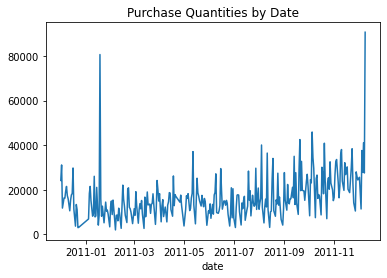

In [11]:
# Examine purchase quantities
date_quantity_series = df.groupby('date')['Quantity'].sum()
date_quantity_series.plot()
plt.title("Purchase Quantities by Date")

Months with the most purchases seem to be December and February.

<AxesSubplot:xlabel='date'>

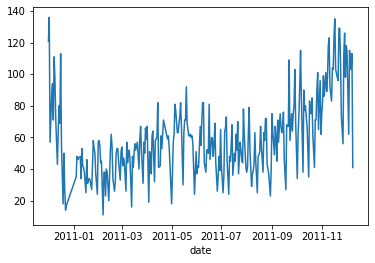

In [15]:
# Examine transactions
date_transaction_series = df.groupby('date')['InvoiceNo'].nunique()
date_transaction_series.plot()

Transactions increase as it gets closer to the year's end (December).
This plot, along with the purchase quantity plot above, shows that there are more purchases and purchases become more frequent towards the year's end.

<AxesSubplot:xlabel='date'>

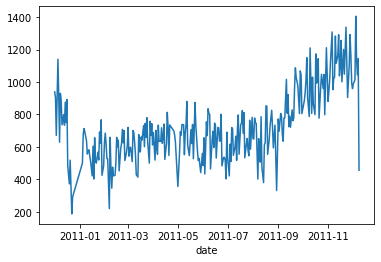

In [14]:
date_unique_item_series = df.groupby('date')['StockCode'].nunique()
date_unique_item_series.plot()

In [16]:
# User analysis - there are 4334 users.
print(len(df['CustomerID'].unique()))

4334


In [17]:
# Purchases per user
customer_unique_transaction_series = df.groupby('CustomerID')['InvoiceNo'].nunique()
customer_unique_transaction_series.describe()

count    4334.000000
mean        4.246654
std         7.642535
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       206.000000
Name: InvoiceNo, dtype: float64

Users, on average, have 4.246654 purchases. Most users have 1 to 5 purchases (Q1 to Q3). 

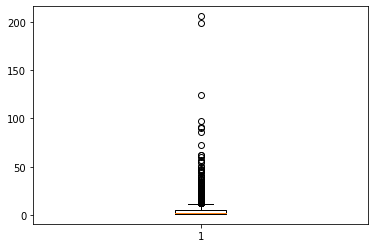

In [18]:
# Visualization
plt.boxplot(customer_unique_transaction_series.values)
plt.show()

There are, however, some extreme outliers, as shown by the boxplot.

In [20]:
customer_unique_item_series = df.groupby('CustomerID')['StockCode'].nunique()
customer_unique_item_series.describe()

count    4334.000000
mean       61.432856
std        85.312937
min         1.000000
25%        16.000000
50%        35.000000
75%        77.000000
max      1786.000000
Name: StockCode, dtype: float64

Users, on average, purchased 61.432856 items. Most users purchase between 16 to 77 items. There is a very extreme outlier of 1786, which is also implied by the large standard deviation of 85.312937. This is also shown through the boxplot below.

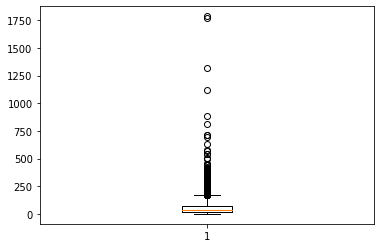

In [21]:
# Visualization through boxplot
plt.boxplot(customer_unique_item_series.values)
plt.show()

As explained above, this dataset will be divided into training and testing datasets.
The training dataset will include data until 2011.11.01. while testing data will include data from 2011.11.01.

In [23]:
import datetime

df_year_round = df[df['date'] < datetime.date(2011, 11, 1)]
df_year_end = df[df['date'] >= datetime.date(2011, 11, 1)]
print(df_year_round.shape)
print(df_year_end.shape)

(314902, 10)
(81568, 10)


In [24]:
customer_item_round_set = df_year_round.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_round_set)

CustomerID
12346.0                                              {23166}
12347.0    {21791, 23170, 20782, 85178, 22697, 85167B, 22...
12348.0    {21977, 22951, 21981, 21982, 21211, 23078, 226...
12350.0    {20652, 22551, 22557, 79066K, 79191C, 22348, 8...
12352.0    {22779, 22413, 84050, 22980, 22634, 21700, 220...
                                 ...                        
18280.0    {22467, 22499, 22495, 22611, 22727, 22084, 221...
18281.0    {23209, 22716, 23007, 22028, 22467, 23008, 22037}
18282.0    {23187, 22089, 21109, 23295, 21108, 22424, 21270}
18283.0    {23253, 21791, 22951, 20725, 21982, 22895, 215...
18287.0    {22114, 22065, 22865, 23267, 22419, 23378, 851...
Name: StockCode, Length: 3970, dtype: object


In [27]:
# Dictionary of what users bought before November (represented by StockCode)
customer_item_dict = {}

# Mark purchases before November as "before"
for customer_id, stocks in customer_item_round_set.items():
    customer_item_dict[customer_id] = {}
    for stock_code in stocks:
        customer_item_dict[customer_id][stock_code] = 'before'

# Print customer ids and print ... afterwards
print(str(customer_item_dict)[:100] + "...")

{12346.0: {'23166': 'before'}, 12347.0: {'21791': 'before', '23170': 'before', '20782': 'before', '8...


In [28]:
# Dictionary of what users bought after November (represented by StockCode)
customer_item_end_set = df_year_end.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_end_set)

CustomerID
12347.0    {23508, 21064, 21731, 21265, 20719, 23506, 234...
12349.0    {21563, 23253, 22556, 37500, 23273, 23514, 232...
12352.0    {23096, 22668, 22624, 23559, 23367, 21669, 226...
12356.0                                       {22423, 21843}
12357.0    {72817, 23317, 37446, 23179, 21232, 21116, 220...
                                 ...                        
18272.0    {22074, 22969, 72799E, 22965, 22960, 72799C, 2...
18273.0                                             {79302M}
18274.0    {23245, 22851, 22720, 22989, 21108, 22423, 845...
18282.0                  {23174, 22818, 22699, 22423, 23175}
18283.0    {21791, 22951, 20725, 22738, 21982, 22382, 475...
Name: StockCode, Length: 1904, dtype: object


In [29]:
# Mark products purchased before November as 'before', after November as 'after', and both as 'both'
for customer_id, stocks in customer_item_end_set.items():
    # if user has purchase history before November
    if customer_id in customer_item_dict:
        for stock_code in stocks:
            # check if product was purchased before
            if stock_code in customer_item_dict[customer_id]:
                customer_item_dict[customer_id][stock_code] = 'both'
            else:
                customer_item_dict[customer_id][stock_code] = 'after'
    else: # if user does NOT have purchase history before November
        customer_item_dict[customer_id] = {}
        for stock_code in stocks:
            customer_item_dict[customer_id][stock_code] = 'new'

print(str(customer_item_dict)[:100] + "...")

{12346.0: {'23166': 'before'}, 12347.0: {'21791': 'before', '23170': 'before', '20782': 'before', '8...


In [35]:
# Convert purchase dictionary into dataframe
columns = ['CustomerID', 'before', 'after', 'both']
df_order_info = pd.DataFrame(columns=columns)

for customer_id in customer_item_dict:
    before = 0
    after = 0
    both = 0
    
    for stock_code in customer_item_dict[customer_id]:
        status = customer_item_dict[customer_id][stock_code]
        if status == 'before':
            before += 1
        elif status == 'after':
            after += 1
        else:
            both += 1
    # append data to df_order_info
    row = [customer_id, before, after, both]
    series = pd.Series(row, index=columns)
    df_order_info = df_order_info.append(series, ignore_index=True)
    
df_order_info.head()

,CustomerID,before,after,both
0,12346.0,1.0,0.0,0.0
1,12347.0,92.0,3.0,8.0
2,12348.0,21.0,0.0,0.0
3,12350.0,16.0,0.0,0.0
4,12352.0,43.0,12.0,2.0


In [36]:
# Number of customers total
print(df_order_info.shape[0])

# before >= 1 && new >= 1 (customers who bought product that they have never bought before November after November)
print(df_order_info[(df_order_info['before'] > 0) & (df_order_info['after'] > 0)].shape[0])

# both >= 1 (customers who repurchased an item)
print(df_order_info[df_order_info['both'] > 0].shape[0])

4334
1446
1790


There are 4334 customers total. 1446 customers have previous purchase history but bought a new product after December. 1790 customers have purchase history and repurchased the item that they bought before.

In [38]:
# Of the customers who bought items after November, how many items did they buy?
print(df_order_info['after'].value_counts()[1:].describe())

count    120.000000
mean      12.075000
std       16.766394
min        1.000000
25%        1.000000
50%        4.000000
75%       14.000000
max       71.000000
Name: after, dtype: float64


On average, customers purchased 12 items after November. The standard deviation, however, is 16.766394 and implies that the distribution is spread out. The median number of purchased items is 4, so customers did not buy many items after November.

In [39]:
# Recommender system is used for customers who have purchased an item before November
# and uses products that were purchased before November.
print(len(df_year_round['CustomerID'].unique()))
print(len(df_year_round['StockCode'].unique()))

3970
3608


This recommendation system will involve 3970 customers and 3608 items.

This dataset does not have ratings that can be used in the Singular Value Decomposition (SVD) model, so feature engineering will be used to derive this information from the data.

In [40]:
# Examine user-item purchase history, create U-I-R dataframe
uir_df = df_year_round.groupby(['CustomerID', 'StockCode'])['InvoiceNo'].nunique().reset_index()
uir_df.head()

,CustomerID,StockCode,InvoiceNo
0,12346.0,23166,1
1,12347.0,16008,1
2,12347.0,17021,1
3,12347.0,20665,1
4,12347.0,20719,3


<AxesSubplot:>

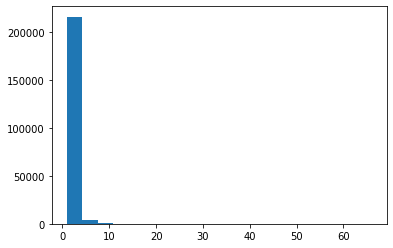

In [41]:
# Visualization - Rating(Invoice No.) feature distribution
uir_df['InvoiceNo'].hist(bins=20, grid=False)

The exploratory data analysis section above confirmed that there are mostly 1 - 5 purchases per consumer, and this histogram confirms this notion. To apply the SVD model and fill the matrix, we will use log normalization.

<AxesSubplot:>

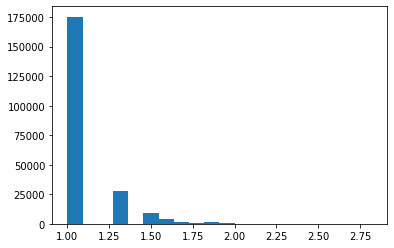

In [42]:
# Log Normalization of Rating(InvoiceNo), and new histogram
uir_df['InvoiceNo'].apply(lambda x: np.log10(x) + 1).hist(bins=20, grid=False)

In [44]:
# Feature scaling - max-min scaling
uir_df['Rating'] = uir_df['InvoiceNo'].apply(lambda x:np.log10(x) + 1)
uir_df['Rating'] = ((uir_df['Rating'] - uir_df['Rating'].min()) / (uir_df['Rating'].max() - uir_df['Rating'].min()) * 4) + 1

In [46]:
# Fill the U-I-R matrix
uir_df = uir_df[['CustomerID', 'StockCode', 'Rating']]
uir_df.head()

,CustomerID,StockCode,Rating
0,12346.0,23166,1.000000
1,12347.0,16008,1.000000
2,12347.0,17021,1.000000
3,12347.0,20665,1.000000
4,12347.0,20719,2.048881


In [49]:
# Test the SVD model
import time
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# Train the SVD model
train_start = time.time()
model = SVD(n_factors=8, lr_all=0.005, reg_all=0.02, n_epochs=200)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# Print RMSE to evaluate model
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 19.99 seconds
RMSE of test dataset in SVD model:
RMSE: 0.3328


0.33278236722177756

In [50]:
# Create training data to use the SVD library. Use entire data before November as full trainset.
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_data = data.build_full_trainset()

# Fit the SVD model
train_start = time.time()
model = SVD(n_factors=8, lr_all=0.005, reg_all=0.02, n_epochs=200)
model.fit(train_data)
train_end = time.time()

Based on the trained SVD model, items can be recommended.
There will be 3 types of recommendations:
1) Recommendation of an item that HAS NOT been bought before
2) Recommendation of an item that HAS been bought before
3) Recommendation of an item from all products, based on user-item ratings.

In [53]:
# 1) Recommendation of an item that HAS NOT been bought before

test_data = train_data.build_anti_testset()
target_user_predictions = model.test(test_data)

new_order_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in new_order_prediction_dict:
        if stock_code in new_order_prediction_dict[customer_id]:
            pass
        else:
            new_order_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        new_order_prediction_dict[customer_id] = {}
        new_order_prediction_dict[customer_id][stock_code] = predicted_rating
        
print(str(new_order_prediction_dict)[:300] + "...")

{12346.0: {'16008': 1, '17021': 1.1729228427470788, '20665': 1, '20719': 1.304226641846802, '20780': 1, '20782': 1.1020227833110239, '20966': 1.0660366035901347, '21035': 1.1125087190767478, '21041': 1.0668490352690931, '21064': 1.2286440132369427, '21154': 1.0715812095022876, '21171': 1, '21265': 1...


In [54]:
# 2) Recommendation of an item that HAS been bought before
test_data = train_data.build_testset()
target_user_predictions = model.test(test_data)

reorder_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in reorder_prediction_dict:
        if stock_code in reorder_prediction_dict[customer_id]:
            pass
        else:
            reorder_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        reorder_prediction_dict[customer_id] = {}
        reorder_prediction_dict[customer_id][stock_code] = predicted_rating
        
print(str(reorder_prediction_dict)[:300] + "...")

{12346.0: {'23166': 1.0405872861291314}, 12347.0: {'16008': 1.1486807767180045, '17021': 1.1752630397350394, '20665': 1.3191537279395738, '20719': 2.097534284794876, '20780': 1.3190245094926243, '20782': 1.1612980959715458, '20966': 1.2997955120352844, '21035': 1.2213051654315616, '21041': 1.4486300...


In [56]:
# 3) Recommendation of an item from all products, based on user-item ratings
total_prediction_dict = {}

for customer_id in new_order_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
        for stock_code, predicted_rating in new_order_prediction_dict[customer_id].items():
            if stock_code not in total_prediction_dict[customer_id]:
                total_prediction_dict[customer_id][stock_code] = predicted_rating

for customer_id in reorder_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in reorder_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            
print(str(total_prediction_dict)[:300] + "...")

{12346.0: {'16008': 1, '17021': 1.1729228427470788, '20665': 1, '20719': 1.304226641846802, '20780': 1, '20782': 1.1020227833110239, '20966': 1.0660366035901347, '21035': 1.1125087190767478, '21041': 1.0668490352690931, '21064': 1.2286440132369427, '21154': 1.0715812095022876, '21171': 1, '21265': 1...


In [57]:
# Create dataframe to test the simulation
simulation_test_df = df_year_end.groupby('CustomerID')['StockCode'].apply(set).reset_index()
simulation_test_df.columns = ['CustomerID', 'RealOrdered']
simulation_test_df.head()

,CustomerID,RealOrdered
0,12347.0,"{23508, 21064, 21731, 21265, 20719, 23506, 234..."
1,12349.0,"{21563, 23253, 22556, 37500, 23273, 23514, 232..."
2,12352.0,"{23096, 22668, 22624, 23559, 23367, 21669, 226..."
3,12356.0,"{22423, 21843}"
4,12357.0,"{72817, 23317, 37446, 23179, 21232, 21116, 220..."


In [58]:
# Add simulation result to dataframe

def add_predicted_stock_set(customer_id, prediction_dict):
    if customer_id in prediction_dict:
        predicted_stock_dict = prediction_dict[customer_id]
        # sort by highest rating
        sorted_stocks = sorted(predicted_stock_dict, key=lambda x : predicted_stock_dict[x], reverse=True)
        return sorted_stocks
    else:
        return None
    
# add simulation result
simulation_test_df['PredictedOrder(New)'] = simulation_test_df['CustomerID'].apply(lambda x: add_predicted_stock_set(x, new_order_prediction_dict))
simulation_test_df['PredictedOrder(Reorder)'] = simulation_test_df['CustomerID'].apply(lambda x: add_predicted_stock_set(x, reorder_prediction_dict))
simulation_test_df['PredictedOrder(Total)'] = simulation_test_df['CustomerID'].apply(lambda x: add_predicted_stock_set(x, total_prediction_dict))

simulation_test_df.head()

,CustomerID,RealOrdered,PredictedOrder(New),PredictedOrder(Reorder),PredictedOrder(Total)
0,12347.0,"{23508, 21064, 21731, 21265, 20719, 23506, 234...","[22326, 22328, 22197, 84086B, 47421, 22556, 21...","[22726, 20719, 22727, 21731, 22728, 22729, 227...","[22326, 22726, 22328, 22197, 20719, 84086B, 22..."
1,12349.0,"{21563, 23253, 22556, 37500, 23273, 23514, 232...",None,None,None
2,12352.0,"{23096, 22668, 22624, 23559, 23367, 21669, 226...","[84086B, 90119, 85131B, 85131D, 21326, 22133, ...","[37448, 21914, 22413, 22993, 22780, 22779, 840...","[84086B, 90119, 85131B, 85131D, 21326, 22133, ..."
3,12356.0,"{22423, 21843}","[84086B, 22727, 90042A, 85131B, 90035A, 90119,...","[22423, 21843, 37450, 22649, 22699, 21094, 210...","[84086B, 22727, 90042A, 85131B, 90035A, 90119,..."
4,12357.0,"{72817, 23317, 37446, 23179, 21232, 21116, 220...",None,None,None


In [59]:
# Above is the test dataset. This section evaluates how close the predictions were in the simulation to the real orders.
def calculate_recall(real_order, predicted_order, k):
    # if there are no recommendations
    if predicted_order is None:
        return None
    
    # SVD model predicts that user will purchase k items with the highest rating
    predicted = predicted_order[:k]
    true_positive = 0
    for stock_code in predicted:
        if stock_code in real_order:
            true_positive += 1
    
    recall = true_positive / len(predicted)
    return recall

In [61]:
# Evaluate recommendations
simulation_test_df['top_k_recall(Reorder)'] = simulation_test_df.apply(lambda x: calculate_recall(x['RealOrdered'], x['PredictedOrder(Reorder)'], 5), axis=1)
simulation_test_df['top_k_recall(New)'] = simulation_test_df.apply(lambda x: calculate_recall(x['RealOrdered'], x['PredictedOrder(New)'], 5), axis=1)
simulation_test_df['top_k_recall(Total)'] = simulation_test_df.apply(lambda x: calculate_recall(x['RealOrdered'], x['PredictedOrder(Total)'], 5), axis=1)

In [62]:
print(simulation_test_df['top_k_recall(Reorder)'].mean())
print(simulation_test_df['top_k_recall(New)'].mean())
print(simulation_test_df['top_k_recall(Total)'].mean())

0.31035714285714094
0.007272727272727272
0.07350649350649374


Recall is TP / (TP + FN), which represents how much of the true purchase the model predicted as true.

On average, the model predicted 31% of reorders, 0.7% of new orders, and 7% of total orders. This recommendation system gives better results when recommending reorders instead of new orders.

In [63]:
# Reorder simulation details
simulation_test_df['top_k_recall(Reorder)'].value_counts()

0.000000    466
0.200000    395
0.400000    293
0.600000    182
0.800000    106
1.000000     79
0.500000      7
0.250000      6
0.666667      4
0.750000      1
0.333333      1
Name: top_k_recall(Reorder), dtype: int64

Recall of 0: 466 consumers are predicted to buy nothing with 5 recommendations.
Recall of 0.2: 395 consumers are predicted to buy 1 item with 5 recommendations.

In [64]:
# New order simulation details
simulation_test_df['top_k_recall(New)'].value_counts()

0.0    1492
0.2      40
0.4       8
Name: top_k_recall(New), dtype: int64

Recall of 0: 1492 consumers are predicted to buy nothing with 5 recommendations.
This implies that this is not an effective recommender system for new orders.

In [65]:
# Total order simulation details
simulation_test_df['top_k_recall(Total)'].value_counts()

0.0    1204
0.2     193
0.4      86
0.6      36
0.8      12
1.0       9
Name: top_k_recall(Total), dtype: int64

Recall of 0: 1204 consumers are predicted to buy nothing with 5 recommendations.
The details of three different recommendations confirm that reorder recommendations are the best simulation for this recommender system.

In [66]:
# Summary of recommender system
k = 5
result_df = simulation_test_df[simulation_test_df['PredictedOrder(Reorder)'].notnull()]
result_df['PredictedOrder(Reorder)'] = result_df['PredictedOrder(Reorder)'].apply(lambda x: x[:k])
result_df = result_df[['CustomerID', 'RealOrdered', 'PredictedOrder(Reorder)', 'top_k_recall(Reorder)']]
# See random sample of size 5 from the dataframe
result_df.sample(5).head()

,CustomerID,RealOrdered,PredictedOrder(Reorder),top_k_recall(Reorder)
1518,17107.0,"{20725, 22697, 23188, 22382, 20685, 21164, 233...","[85123A, 22178, 48187, 20685, 85099B]",0.4
1378,16711.0,"{22593, 35970, 23012, 21167, 85107, 23100, 224...","[22424, 15056N, 23013, 23188, 22425]",0.2
544,14044.0,"{23265, 23273, 23263, 22338, 85123A, 22337, 23...","[20725, 85123A, 22383, 20727, 23206]",0.2
697,14525.0,"{23102, 82483, 21682, 22800, 23571, 85123A, 22...","[85123A, 82482, 21754, 85099B, 22333]",0.6
1620,17419.0,"{22112, 23340, 23355, 23284, 23571, 23499, 226...","[84879, 21314, 82482, 85123A, 84406B]",0.2
